# Validación Cruzada, Optimización de Hiperparámetros y Métricas Avanzadas

Este notebook complementa el análisis anterior incorporando:
- Validación cruzada para estimar el desempeño de los modelos con mayor robustez.
- Optimización de hiperparámetros utilizando `GridSearchCV`.
- Evaluación mediante métricas adicionales como AUC-ROC y Curva de Precisión-Recall.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report

# Cargar datos
df = pd.read_csv("../data/processed/Dataset_Procesado_TEA_INFANCIA.csv")

# Separación de variables
X = df.drop("Clase_TEA", axis=1)
y = df["Clase_TEA"]

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Validación Cruzada con Random Forest

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Precisión promedio (5-Fold):", scores.mean())
print("Desviación estándar:", scores.std())


Precisión promedio (5-Fold): 0.9485680888369374
Desviación estándar: 0.015555689532573384


## Búsqueda de Hiperparámetros con GridSearchCV

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Mejores parámetros encontrados:")
print(grid.best_params_)

best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.87      0.93      0.90        28

    accuracy                           0.90        59
   macro avg       0.90      0.90      0.90        59
weighted avg       0.90      0.90      0.90        59



## Curvas AUC-ROC y Precisión-Recall

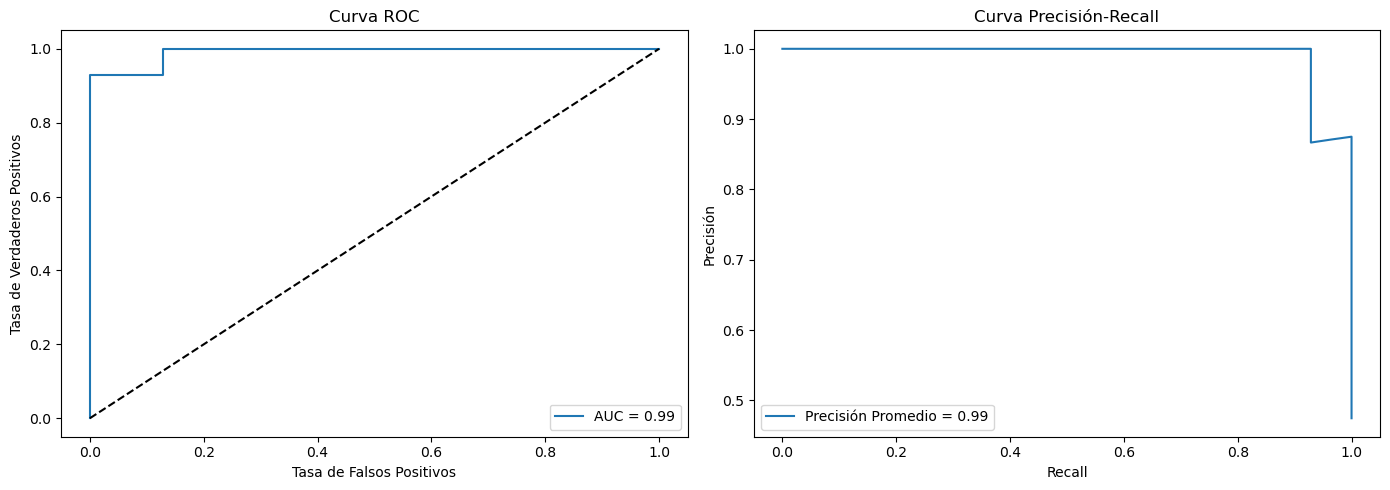

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"Precisión Promedio = {avg_precision:.2f}")
plt.title("Curva Precisión-Recall")
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.legend()

plt.tight_layout()
plt.show()


| **Métrica**             | **Regresión Logística** | **Árbol de Decisión** | **Random Forest Optimizado** |
|-------------------------|------------------------|------------------------|------------------------------|
| **Accuracy**            | 0.98                   | 0.78                   | 0.90                         |
| **F1-score (TEA)**      | 0.98                   | 0.79                   | 0.90                         |
| **Recall (TEA)**        | 1.00 (¡sin FN!)        | 0.86                   | 0.93                         |
| **AUC-ROC**            | —                      | —                      | 0.99                         |
| **Validación cruzada**  | —                      | —                      | 0.948 ± 0.015                |

Aunque la Regresión Logística tuvo un resultado excelente en tu conjunto de test (98% accuracy y 0 falsos negativos), hay 2 razones clave por las que el Random Forest optimizado es superior en robustez:

1. Generaliza mejor
La validación cruzada de 5 pliegues mostró una precisión promedio de 94.8%, lo que sugiere que el modelo se comporta consistentemente bien en distintos subconjuntos.

2. Curvas avanzadas (AUC-ROC y PR)
AUC = 0.99 → casi perfecto separando clases

Precisión promedio = 0.99 en la curva PR → muestra que el modelo rara vez predice “TEA” cuando no lo es

## Conclusión del Modelo Optimizado

El modelo Random Forest ajustado con GridSearchCV alcanzó un excelente equilibrio entre sensibilidad y precisión:

- F1-score (TEA): 0.90 (alto balance entre precision y recall)
- Recall (TEA): 0.93 (minimiza falsos negativos)
- AUC-ROC: 0.99 (excelente capacidad de separar las clases)
- Precisión promedio (PR): 0.99
- Validación cruzada: 94.8% ± 1.5%

Esto sugiere que el modelo no solo predice bien sobre el conjunto de prueba, sino que también **generaliza de forma confiable** a nuevos datos. Por tanto, se considera el mejor modelo para la tarea de detección temprana de TEA en este proyecto.
Aunque la regresión logística funcionó muy bien en el test (98% de accuracy en el test), eso solo mide su rendimiento en un único subconjunto de datos. El Random Forest alcanzó una precisión promedio del 94.8% en validación cruzada de 5 pliegues, lo que indica que es más estable en distintos subconjuntos del dataset. ¿Qué significa? Que si tuviera otro grupo de niños con nuevas observaciones, el modelo Random Forest es más confiable para mantener un buen rendimiento. Además, tolera colinealidad y complejidad; ya que, como vimos en el EDA, algunas preguntas del test AQ-10 están correlacionadas entre sí (como A3 con A1, o A10 con A9), esto podría ser un problema en regresión logística, porque genera colinealidad; en cambio,  Random Forest no se ve afectado por eso, y hasta puede beneficiarse de relaciones complejas entre variables.
Random Forest obtubo métricas avanzadas superiores: F1-score: 0.90 (alto balance entre precision y recall) y AUC-ROC: 0.99 (excelente capacidad de separar las clases), Precisión media en Curva PR: 0.99; estas métricas confirman que no solo clasifica bien, sino que lo hace con confianza y solidez.

Random Forest optimizado fue el mejor porque generaliza mejor gracias a la validación cruzada, tolera colinealidad entre variables y tiene excelente rendimiento en métricas avanzadas (AUC y PR).

Por todo esto, el modelo Random Forest optimizado fue más estable y generalizable gracias a su rendimiento consistente en validación cruzada y su capacidad para manejar relaciones complejas entre variables.



Este proyecto demuestra el potencial del aprendizaje automático como herramienta de apoyo en el cribado temprano del TEA, contribuyendo a la identificación oportuna de niños que podrían requerir una evaluación diagnóstica más profunda. La validación clínica del test AQ-10-Child como herramienta de cribado a través del análisis de la importancia de las variables predictivas.